In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# 1. Data import

In [2]:
telco = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [3]:
telco.shape

(7043, 21)

customerID: Customer ID \
genderCustomer: gender (female, male) \
SeniorCitizen: Whether the customer is a senior citizen or not (1, 0) \
PartnerWhether: the customer has a partner or not (Yes, No) \
Dependents: Whether the customer has dependents or not (Yes, No)\
tenure: Number of months the customer has stayed with the company \
PhoneService: Whether the customer has a phone service or not (Yes, No) \
MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service) \
InternetService: Customer’s internet service provider (DSL, Fiber optic, No) \
OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service) \
OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service) \
DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service) \
TechSupport: Whether the customer has tech support or not (Yes, No, No internet service) \
StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service) \
StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service) \
Contract: The contract term of the customer (Month-to-month, One year, Two year)  \
PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) \
MonthlyCharges: The amount charged to the customer monthly \
TotalCharges: The total amount charged to the customer \
Churn: Whether the customer churned or not (Yes or No) \


In [4]:
# Essential functions
def check_missing_data(df): # function to count number of nans in each column and percentage of nans in that columns
    total = df.isnull().sum().sort_values(ascending = False)
    percent = ((df.isnull().sum()/len(df)) *100).sort_values(ascending = False)
    res = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    res = res[res["Total"] != 0]
    return res


def find_high_corr_pair(df): # finding highly correlated pairs in a dataframe
    corr_matrix = df.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    temp = []
    for col in upper.columns:
        for ind in upper.index:
            if upper.loc[ind, col] > 0.9:
                temp.append((col, ind))
    return temp # return a list of tuples with highly correlated pair

# find descriptions of a column

def search_description(col_name, table_name):
    description = pd.read_csv("../input/home-credit-default-risk/HomeCredit_columns_description.csv", encoding= "ISO-8859-1")
    description = description[description["Table"] == table_name][["Row", "Description"]]
    return description[description["Row"] == col_name].values

def remove_outliers_iqr(df, column):
    q75, q25 = np.percentile(df[column], [75 ,25])
    IQR = q75 - q25
    fence_low = q25 - 1.5 * IQR 
    fence_high = q75 + 1.5 * IQR
    df_out = df.loc[(df[column] < fence_low) | (df[column] > fence_high)]
    df[column].iloc[df_out.index] = np.nan
    return df

def count_outliers_iqr(df, column):
    q75, q25 = np.percentile(df[column], [75 ,25])
    IQR = q75 - q25
    fence_low = q25 - 1.5 * IQR 
    fence_high = q75 + 1.5 * IQR
    df_out = df.loc[(df[column] < fence_low) | (df[column] > fence_high)]
    return len(df_out)

def plot_numeric_dist(table, column):
    plt.figure(figsize=(12,5))
    plt.title(f"Distribution of {column}")
    ax = sns.distplot(table[column])

def plot_pie(table, column):
    fig, ax =plt.subplots(figsize = (10, 4))
    data = table[column].value_counts()
    ax.pie(data.values, labels=data.index, autopct='%1.1f%%')
    
def delete_spine2(ax):
    for i in ["top", "right"]:
        ax.spines[i].set_visible(False)

# 2. Clean data

## 2.1 Handling missing value

In [5]:
telco["TotalCharges"].replace(" ", np.nan, inplace=True)
telco["TotalCharges"] = telco["TotalCharges"].astype("float64")

In [6]:
check_missing_data(telco)

,Total,Percent
TotalCharges,11,0.156183


In [7]:
# 0.15% data is missing in TotalCharges column we can drop this 11 row
telco.dropna(axis = 0, inplace=True)
check_missing_data(telco)

,Total,Percent


## 2.2 Transform data type

In [8]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [9]:
telco["TotalCharges"].unique()

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [10]:
for i in telco.select_dtypes("object").columns:
    print(i, telco[i].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [11]:
telco["OnlineBackup"].value_counts()

No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64

In [12]:
telco[telco["TotalCharges"] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [13]:
telco[telco["Contract"] == "Two year"]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
11,7469-LKBCI,Male,0,No,No,16,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),18.95,326.80,No
15,3655-SNQYZ,Female,0,Yes,Yes,69,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),113.25,7895.15,No
17,9959-WOFKT,Male,0,No,Yes,71,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),106.70,7382.25,No
23,3638-WEABW,Female,0,Yes,No,58,Yes,Yes,DSL,No,Yes,No,Yes,No,No,Two year,Yes,Credit card (automatic),59.90,3505.10,No
28,5248-YGIJN,Male,0,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),90.25,6369.45,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,4807-IZYOZ,Female,0,No,No,51,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.65,1020.75,No
7019,9710-NJERN,Female,0,No,No,39,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.15,826.00,No
7028,9281-CEDRU,Female,0,Yes,No,68,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),64.10,4326.25,No
7037,2569-WGERO,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No


In [14]:
telco["SeniorCitizen"].value_counts()

0    5890
1    1142
Name: SeniorCitizen, dtype: int64

In [15]:
telco["Partner"].unique()

array(['Yes', 'No'], dtype=object)

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


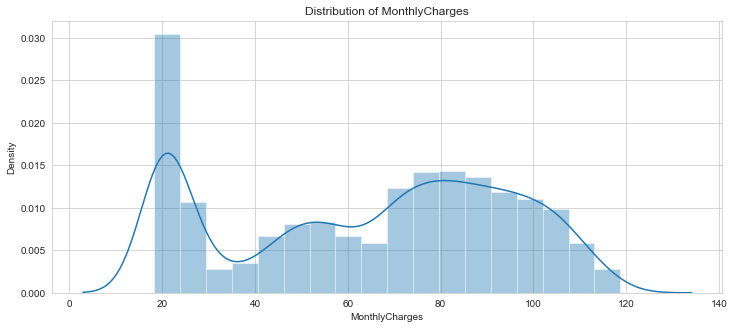

In [16]:
plot_numeric_dist(telco, "MonthlyCharges")

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


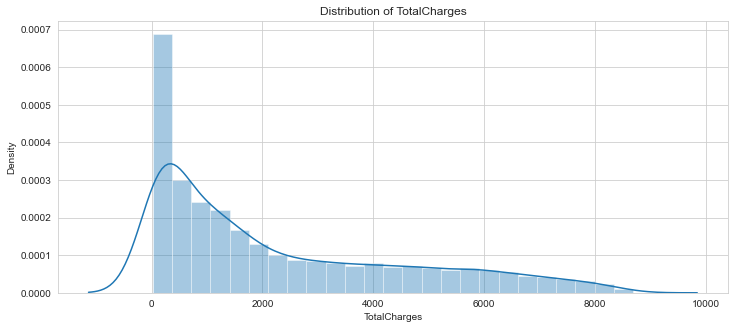

In [17]:
plot_numeric_dist(telco, "TotalCharges")

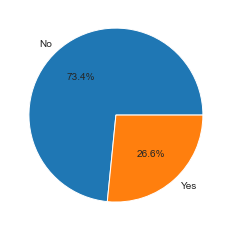

In [18]:
plot_pie(telco, "Churn")

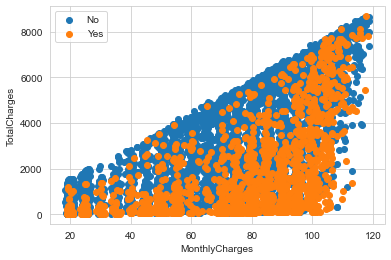

In [19]:
fig, ax = plt.subplots()
ax.scatter(telco[telco["Churn"] == "No"]["MonthlyCharges"], telco[telco["Churn"] == "No"]["TotalCharges"], label = "No")
ax.scatter(telco[telco["Churn"] == "Yes"]["MonthlyCharges"], telco[telco["Churn"] == "Yes"]["TotalCharges"], label = "Yes")
ax.set_xlabel("MonthlyCharges")
ax.set_ylabel("TotalCharges")
ax.legend()

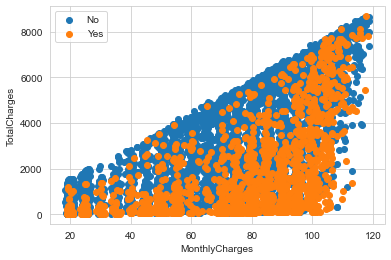

In [20]:
fig, ax = plt.subplots()
ax.scatter(telco[telco["Churn"] == "No"]["MonthlyCharges"], telco[telco["Churn"] == "No"]["TotalCharges"], label = "No")
ax.scatter(telco[telco["Churn"] == "Yes"]["MonthlyCharges"], telco[telco["Churn"] == "Yes"]["TotalCharges"], label = "Yes")
ax.set_xlabel("MonthlyCharges")
ax.set_ylabel("TotalCharges")
ax.legend()

In [21]:
telco_gr_churn = telco.groupby("Churn")

In [22]:
telco_gr_churn["SeniorCitizen"].value_counts()

Churn  SeniorCitizen
No     0                4497
       1                 666
Yes    0                1393
       1                 476
Name: SeniorCitizen, dtype: int64

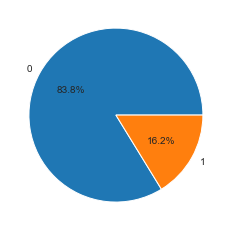

In [23]:
plot_pie(telco, "SeniorCitizen")

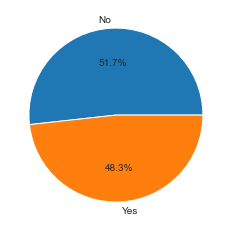

In [24]:
plot_pie(telco, "Partner")

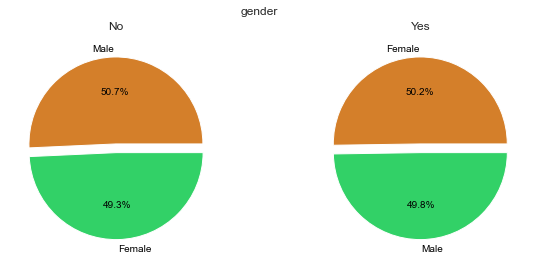

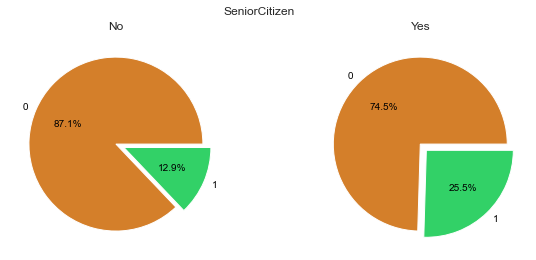

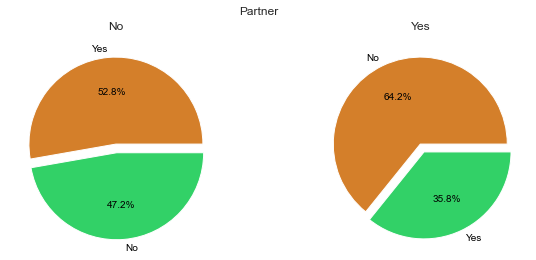

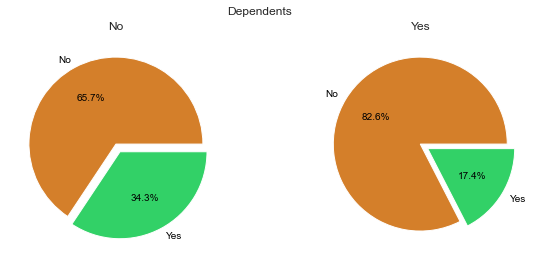

In [25]:
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
background_related = telco[['gender', 'SeniorCitizen', 'Partner', 'Dependents', "Churn"]]
background_related_gr = background_related.groupby("Churn")
titles = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', "Churn"]
churn_val = telco["Churn"].unique()
for i in range(len(cols)):
    fig, (ax, ax1) = plt.subplots(ncols = 2, figsize = (10, 4))
    axes = (ax, ax1)
    temp = background_related.groupby("Churn")[cols[i]].value_counts(normalize = True)
    fig.suptitle(titles[i])
    for j in range(2):
        data = temp.loc[churn_val[j]]
        axes[j].pie(data.values, labels=data.index, autopct='%1.1f%%', colors = ["#d47f2a", "#32d167"], textprops=dict(color="black"), explode = (0, 0.1))
        axes[j].set_title(churn_val[j])

In [26]:
temp = background_related.groupby("Churn")[cols[0]].value_counts(normalize = True)
temp

Churn  gender
No     Male      0.507263
       Female    0.492737
Yes    Female    0.502408
       Male      0.497592
Name: gender, dtype: float64

In [27]:
temp.loc["Yes"]

gender
Female    0.502408
Male      0.497592
Name: gender, dtype: float64

In [28]:
temp.loc["No"].values

array([0.50726322, 0.49273678])

([<matplotlib.patches.Wedge at 0x2430bf9b6d0>,
 [Text(-0.025097788552290785, 1.0997136450048188, ''),
  Text(0.02737951801626847, -1.1996876101690794, '')],
 [Text(-0.013689702846704063, 0.5998438063662648, '50.7%'),
  Text(0.01597138550948994, -0.6998177725986295, '49.3%')])

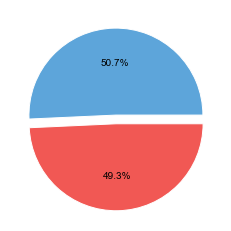

In [29]:
temp = background_related.groupby("Churn")[cols[0]].value_counts(normalize = True)
plt.pie(temp[[0, 1]].values, autopct='%1.1f%%', colors = ["#5da5da", "#f15854"], textprops=dict(color="black"), explode = (0, 0.1))

In [30]:
temp[[0, 1]]

Churn  gender
No     Male      0.507263
       Female    0.492737
Name: gender, dtype: float64

# 3. Feature egineering

In [31]:
telco.select_dtypes("object").columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [32]:
telco_transformed = telco.copy()

In [33]:
cols = ["MultipleLines", 'InternetService', "Contract", "PaymentMethod", 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in cols:
    cols_dummy = pd.get_dummies(telco_transformed[i], prefix = i , drop_first= True)
    telco_transformed = pd.concat([telco_transformed, cols_dummy], axis=1)
    telco_transformed.drop(i, axis = 1, inplace= True)

In [34]:
telco_transformed

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,Yes,29.85,29.85,No,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,56.95,1889.50,No,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,Yes,53.85,108.15,Yes,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No,42.30,1840.75,No,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,Yes,70.70,151.65,Yes,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,84.80,1990.50,No,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,103.20,7362.90,No,0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,Yes,29.60,346.45,No,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,74.40,306.60,Yes,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
from sklearn.preprocessing import LabelEncoder
label_enc_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
telco_transformed[label_enc_cols] = telco[label_enc_cols].apply(LabelEncoder().fit_transform)
telco_transformed

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,1,84.80,1990.50,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1
7039,2234-XADUH,0,0,1,1,72,1,1,103.20,7362.90,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1
7040,4801-JZAZL,0,0,1,1,11,0,1,29.60,346.45,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
7041,8361-LTMKD,1,1,1,0,4,1,1,74.40,306.60,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
from sklearn.preprocessing import MinMaxScaler
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for i in cols:
    mm_scale = MinMaxScaler()
    telco_transformed[i] = mm_scale.fit_transform(telco_transformed[[i]])
telco_transformed

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,0,0,1,0,0.000000,0,1,0.115423,0.001275,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,0.464789,1,0,0.385075,0.215867,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3668-QPYBK,1,0,0,0,0.014085,1,1,0.354229,0.010310,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,0.619718,0,0,0.239303,0.210241,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,0.014085,1,1,0.521891,0.015330,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,0.323944,1,1,0.662189,0.227521,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1
7039,2234-XADUH,0,0,1,1,1.000000,1,1,0.845274,0.847461,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1
7040,4801-JZAZL,0,0,1,1,0.140845,0,1,0.112935,0.037809,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
7041,8361-LTMKD,1,1,1,0,0.042254,1,1,0.558706,0.033210,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
telco.select_dtypes(np.number).columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

df_transform

In [38]:
X = telco_transformed.drop(["customerID", "Churn"], axis = 1)
Y = telco_transformed["Churn"]

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.3, random_state=99)

In [40]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

num_fold = 19
seed = 99
kfold = KFold(n_splits= num_fold, random_state=seed, shuffle=True)

rf_model = RandomForestClassifier()
results = cross_val_score(rf_model, x_train, y_train, cv = kfold)
for i in range(10):
    print("accuracy on fold " + str(i), results[i] * 100)

accuracy on fold 0 80.0
accuracy on fold 1 75.67567567567568
accuracy on fold 2 71.81467181467181
accuracy on fold 3 80.3088803088803
accuracy on fold 4 79.92277992277992
accuracy on fold 5 76.44787644787645
accuracy on fold 6 78.37837837837837
accuracy on fold 7 79.53667953667953
accuracy on fold 8 80.6949806949807
accuracy on fold 9 77.99227799227799


In [41]:
scoring = "roc_auc"
print(results.mean(), results.std())

0.7781345255029466 0.029041593221074222


LR: 0.795611 (0.024118)
KNN: 0.757618 (0.025296)
DT: 0.720440 (0.025207)
SVC: 0.787685 (0.026803)
RFC: 0.778138 (0.025256)


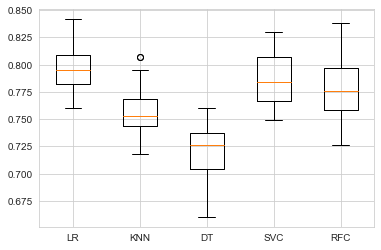

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = [('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ("DT", DecisionTreeClassifier()), ("SVC", SVC()), ('RFC', RandomForestClassifier())]
results = []
names = []
scoring = 'roc_auc'

for name, model in models:
    kfold = KFold(n_splits= num_fold, random_state=seed, shuffle=True)
    result = cross_val_score(model, x_train, y_train, cv = kfold)

    msg = "%s: %f (%f)" % (name, result.mean(), result.std())
    print(msg)
    results.append(result)
    names.append(name)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

chay random search tuning logistic

train 4 model 